In [2]:
'''math tool'''
import csv
import numpy as np
from scipy.spatial import distance as dist

'''plot tool'''
import matplotlib.pyplot as plt

'''image tool'''
import cv2
import statistics as sta

import utm
from pyproj import Proj
import time
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/mapping_node/mapping_ws/src/mapping_explorer/0906_demo_data/2tree/"
    # test_data/
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
else:
    file_path = r"C:/Users/15sin/OneDrive/文件/GitHub/mapping_explorer/test_data/"

in linux


In [3]:
P = np.array([[ 352847.76728117,  352851.45617005,  352865.55140815,  352870.92283672],
                 [2767650.49778999, 2767651.60890111, 2767652.14223444, 2767648.74223444]])
# U = np.array([[ 352845.32283672,  352848.97283672],
#                  [2767649.69223444, 2767651.09223444]])
U = np.array([[ 352845.32283672,  352848.97283672],
                 [2767649.69223444, 2767651.09223444]])

In [4]:
def find_second(row_index, first_min):
    second_min = 100
    sm_index = 0
    row_list = D[row_index,:]
    for i in range(len(row_list)):
        if row_list[i] != first_min:
            if row_list[i] < second_min:
                second_min = row_list[i]
                sm_index = i
    
    return second_min, sm_index

In [5]:
D = dist.cdist(U.T, P.T)
rows = D.min(axis=1).argsort()
cols = D.argmin(axis=1)
print(D)
print('match point: ', list(enumerate(cols)))

for a in range(len(cols)):
    b=1
    while a+b < len(cols):
        if cols[a] == cols[a+b]:
            print("matched same ref landmarks!")
            second_min_A,A = find_second(a,D[a,cols[a]])
            second_min_B,B = find_second(a+b,D[a+b,cols[a+b]])
            if second_min_A>second_min_B:
                cols[a+b]=B
            elif second_min_A<second_min_B:
                cols[a]=A
            print('changed point: ', list(enumerate(cols)))
        b+=1

Q = np.zeros(U.shape)
for (i, col) in enumerate(cols):
    Q[:,i] = P[:,col]

[[ 2.57375764  6.4258376  20.37639816 25.61762089]
 [ 1.34414597  2.53651116 16.61178891 22.07543884]]
match point:  [(0, 0), (1, 0)]
matched same ref landmarks!
changed point:  [(0, 0), (1, 1)]


In [6]:
Q

array([[ 352847.76728117,  352851.45617005],
       [2767650.49778999, 2767651.60890111]])

In [7]:
# centerize
U_bar = np.array([np.average(U, axis=1)])
U_bar = U_bar.T
Q_bar = np.array([np.average(Q, axis=1)])
Q_bar = Q_bar.T
print(U_bar)
X = U-U_bar
Y = Q-Q_bar
S = X @ Y.T
u, s, vh = np.linalg.svd(S)
# check u, vh det
print('det(vh@u.T): ',np.linalg.det(vh@u.T))
det = np.linalg.det(vh@u.T)
if det>0:
    tmp = np.array([[1,0],[0,1]])
    
else: 
    tmp = np.array([[1,0],[0,-1]])
    
R = vh @ tmp @ u.T
t = Q_bar-U_bar

print('R: ',R)
print('theta (deg): ',(np.arctan2(-R[1,0], R[0,0]))/np.pi*180)
print('translation: ',t)

[[ 352847.14783672]
 [2767650.39223444]]
det(vh@u.T):  -1.0000000000000002
R:  [[ 0.79071679  0.61218212]
 [-0.61218212  0.79071679]]
theta (deg):  37.74745246526105
translation:  [[2.46388889]
 [0.66111111]]


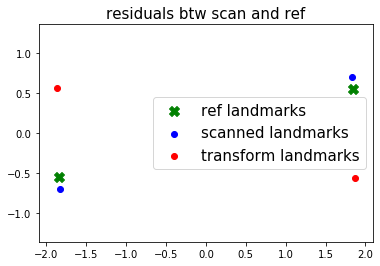

In [10]:
U_new = R@X#+U_bar+t
# utm_loc = np.array([[utm_x_loc],[utm_y_loc]])
# utm_loc_decentral = utm_loc-U_bar
# utm_loc_new = R@utm_loc_decentral+U_bar+t
plt.scatter(Y[0,:], Y[1,:], c='g', label='ref landmarks', marker='X', s=100)
plt.scatter(X[0,:], X[1,:], label='scanned landmarks',c='b')
# plt.scatter(utm_loc_decentral[0], utm_loc_decentral[1], label='origin pose',c='b', marker="v")
# plt.scatter(w[0], w[1], label='origin pose',c='orange', marker="v")
# plt.scatter(U_bar[0], U_bar[1], label='origin pose',c='black', marker="v")
plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
# plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend(fontsize=15)
plt.show()